In [292]:
import pandas as pd
pd.set_option( 'display.max_columns', None )

data_path = r"C:\Users\cansu\Downloads\Motor_Vehicle_Collisions_-_Crashes_20240919.csv"
df = pd.read_csv(data_path)
df = df.drop( columns = ['BOROUGH','ZIP CODE','LOCATION'])
df.head()

C:\Users\cansu\AppData\Local\Temp\ipykernel_6492\697431787.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,12/14/2021,3:43,40.804375,-73.937420,LEXINGTON AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486304,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
1,12/14/2021,17:31,40.623104,-73.958090,EAST 18 STREET,AVENUE K,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486516,Sedan,NaN,NaN,NaN,NaN
2,12/14/2021,12:54,40.687534,-73.977500,FULTON STREET,SAINT FELIX STREET,NaN,1.0,0.0,0,0,1,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4487052,Sedan,Bike,NaN,NaN,NaN
3,12/14/2021,16:25,40.784615,-73.953964,EAST 93 STREET,NaN,NaN,1.0,0.0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4486581,Van,Bike,NaN,NaN,NaN
4,12/16/2021,6:59,NaN,NaN,KINGSLAND AVENUE,MEEKER AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Traffic Control Disregarded,NaN,NaN,NaN,NaN,4486960,NaN,NaN,NaN,NaN,NaN


In [293]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

print( df.shape[0])
print( df['CRASH DATE'].min() , df['CRASH DATE'].max() )
df = df[df['CRASH DATE'].dt.year >= 2014 ]
print( df.shape[0])

173960
2012-07-01 00:00:00 2024-09-15 00:00:00
150566


In [294]:
import geopandas as gpd
import matplotlib.pyplot as plt

df = df[ df['LATITUDE'].notnull() & df['LONGITUDE'].notnull() ]
print(df.shape[0])


138935


In [295]:
gdf = gpd.GeoDataFrame(df.drop(['LATITUDE','LONGITUDE'], axis=1), geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']), crs=4326 )
gdf = gdf.to_crs( 2263 )

gdf = gdf[ gdf.geometry.x < 2000000 ]
print( gdf.shape[0])

gdf.geometry.x.min(), gdf.geometry.x.max(), gdf.geometry.y.min(), gdf.geometry.y.max()

138350


(914159.0137763288, 1067216.3574280662, 123035.17476027925, 271791.9293385127)

In [296]:
def create_hex_grid( data , dist ):
    import numpy as np
    from shapely.geometry import Polygon
    from math import sin, radians

    xmin, ymin, xmax, ymax = data.total_bounds

    xcoords = np.arange(xmin, xmax, dist*1.5)
    ycoords = np.arange(ymin, ymax, dist* sin(radians(60)) *0.5)

    def create_grid(xcoords, ycoords, dist):
        points = []
        for count,y in enumerate(ycoords):
            if count % 2 == 0: # even
                for x in xcoords:
                    points.append( (x,y) )
            else:
                for x in xcoords:
                    points.append( (x + (dist*0.75), y) )
        return points

    def hexagon(point, dist):
        # 180 degrees in rad
        from math import pi, sin, cos
        circle = 2*pi
        radius = dist/2

        # get 6 point coordinaties for a hexagon
        x = [ point[0] + radius * cos( i * circle / 6 ) for i in range(6) ]
        y = [ point[1] + radius * sin( i * circle / 6 ) for i in range(6) ]
        x.append( x[0] )
        y.append( y[0] )

        return list(zip(x,y))

    grid_points = create_grid(xcoords, ycoords, dist)
    hex_points = [ hexagon(i, dist) for i in grid_points ]
    hex_polygons = gpd.GeoDataFrame( geometry = [Polygon(i) for i in hex_points], crs=data.crs )
    hex_polygons['id'] = [i for i in range( len( hex_polygons ) ) ]
    return hex_polygons

hexs = create_hex_grid( gdf, 5820/4 )
hexs.head()

,geometry,id
0,"POLYGON ((914886.514 123035.175, 914522.764 12...",0
1,"POLYGON ((917069.014 123035.175, 916705.264 12...",1
2,"POLYGON ((919251.514 123035.175, 918887.764 12...",2
3,"POLYGON ((921434.014 123035.175, 921070.264 12...",3
4,"POLYGON ((923616.514 123035.175, 923252.764 12...",4


In [297]:
bb = gpd.read_file("D:\DATA\Borough Boundaries.geojson", crs=4326 )
bb = bb.to_crs( 2263 )

hexs_filtered = gpd.sjoin(hexs, bb, how='inner', predicate='intersects')
hexs_filtered = hexs_filtered.dropna( subset=['boro_name'], axis=0 ).drop(columns=['index_right','boro_code','boro_name','shape_area','shape_leng'])

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\cansu\AppData\Local\Temp\ipykernel_6492\310904417.py:1: SyntaxWarning: invalid escape sequence '\D'
  bb = gpd.read_file("D:\DATA\Borough Boundaries.geojson", crs=4326 )


Text(0.0, 1.0, 'Hex Grids (1/4mi)\noverlaied a sample(n=800) from dataset')

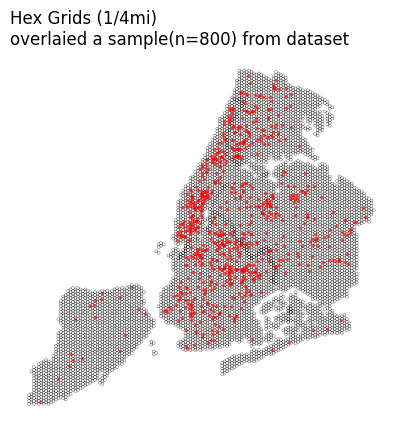

In [298]:
fig,ax = plt.subplots()
hexs_filtered.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax)
gdf.sample(800).plot(ax=ax, markersize=2, color='red', alpha=0.5)
plt.axis('off')
plt.title( "Hex Grids (1/4mi)\noverlaied a sample(n=800) from dataset", loc='left')

In [299]:
gdf2 = gpd.sjoin( gdf, hexs_filtered, how='inner', op='intersects' )
gdf2 = gdf2[ gdf2['id'].notnull() ]
gdf2 = gdf2.dropna( axis=1, how='all' )
gdf2.head()

c:\Users\cansu\.conda\envs\New_Analysis\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,CRASH DATE,CRASH TIME,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry,index_right,id
0,2021-12-14,3:43,LEXINGTON AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4486304,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (1001575.066 232338.720),12394,12394
847,2021-04-27,17:00,EAST 124 STREET,PARK AVENUE,NaN,1.0,0.0,0,0,1,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4411288,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (1000988.149 232340.858),12394,12394
1512,2021-12-20,18:25,EAST 124 STREET,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Aggressive Driving/Road Rage,NaN,NaN,NaN,NaN,4488603,Sedan,NaN,NaN,NaN,NaN,POINT (1001436.818 232091.238),12394,12394
3347,2021-06-01,23:35,EAST 124 STREET,LEXINGTON AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4422863,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (1001436.818 232091.238),12394,12394
4399,2021-10-10,20:31,EAST 124 STREET,LEXINGTON AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,4466092,NaN,NaN,NaN,NaN,NaN,POINT (1001436.818 232091.238),12394,12394


In [300]:
import numpy as np

# if the contributing factor 1 contains the word cell phone, we will categorize it as 'Cell Phone'
gdf2 = gdf2[ gdf2['id'].notnull() ].copy()

gdf2['CONTRIBUTING FACTOR VEHICLE 1'] = gdf2['CONTRIBUTING FACTOR VEHICLE 1'].replace({'Cell Phone (hand-Held)':'Cell Phone', 'Cell Phone (hand-held)':'Cell Phone', 'Cell Phone (hands-free)':'Cell Phone' , 'Texting':'Cell Phone'})
gdf2['CONTRIBUTING FACTOR VEHICLE 1'] = gdf2['CONTRIBUTING FACTOR VEHICLE 1'].replace({'Drugs (Illegal)': "Drugs", 'Drugs (illegal)':'Drugs'  })
gdf2['CONTRIBUTING FACTOR VEHICLE 1'] = gdf2['CONTRIBUTING FACTOR VEHICLE 1'].replace({'Illnes': "Illness"  })

# 1. remove useless factor rows, groupby id and make a list of all factors.
factors = gdf2[ ~gdf2['CONTRIBUTING FACTOR VEHICLE 1'].isin(['Unspecified','','80','nan',np.nan]) ].dropna(subset=['CONTRIBUTING FACTOR VEHICLE 1']).groupby('id').agg({'CONTRIBUTING FACTOR VEHICLE 1':list})

# count occurrences of each contributing factor
factors = factors.explode('CONTRIBUTING FACTOR VEHICLE 1').groupby(['id','CONTRIBUTING FACTOR VEHICLE 1']).size().reset_index(name='counts').pivot(index='id', columns='CONTRIBUTING FACTOR VEHICLE 1', values='counts')
factors = factors[ factors.sum()[factors.sum() > 5 ].index ]

factor_dict = []
for i,r in factors.iterrows():

    r = r.dropna()
    r = r.astype(int)
    r = r.to_dict()
    factor_dict.append( r )

print( factors.shape[0] , 'hexes have information' )

4579 hexes have information


Get simpler counts from injury and killed data

In [301]:
total_tally = gdf2.groupby('id').agg({
    'NUMBER OF PEDESTRIANS INJURED': 'sum',
    'NUMBER OF PEDESTRIANS KILLED':'sum',
    'NUMBER OF CYCLIST INJURED':'sum',
    'NUMBER OF CYCLIST KILLED':'sum'
})

total_tally.columns = ['pedestrians_injured', 'pedestrians_killed', 'cyclists_injured', 'cyclists_killed']
total_tally['total'] = total_tally.sum(axis=1)
total_tally['total_cycle'] = total_tally['cyclists_injured'] + total_tally['cyclists_killed']
total_tally['total_ped'] = total_tally['pedestrians_injured'] + total_tally['pedestrians_killed']

total_tally.sort_values('total', ascending=False).head(10)

,pedestrians_injured,pedestrians_killed,cyclists_injured,cyclists_killed,total,total_cycle,total_ped
id,,,,,,,
8837,134,0,175,0,309,175,134
10400,208,1,93,0,302,93,209
9904,151,0,118,0,269,118,151
10117,155,0,88,0,243,88,155
10046,141,0,98,0,239,98,141
12893,174,0,63,0,237,63,174
8062,140,0,92,1,233,93,140
10615,141,1,88,1,231,89,142
10470,159,0,69,1,229,70,159


1.2336659188827521 0.583534607749217


Text(0.0, 1.0, 'Correlation between Ped and Cycllist Injuries\nR2: 0.58')

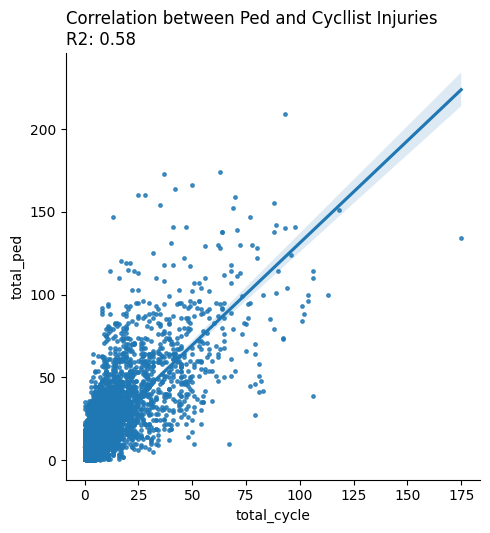

In [302]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def linear_regression( x,y ):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    x = x-np.min(x) # get it to 0
    y = y-np.min(y) +1 # get it to 0

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]

    r2 = r2_score(y, model.predict(x))

    return slope, r2

slope , r2 = linear_regression( total_tally['total_cycle'] , total_tally['total_ped'])
print( slope, r2 )

sns.lmplot(
    data = total_tally,
    x = 'total_cycle',
    y = 'total_ped',
    scatter_kws={'s':6, 'ec':None}
)

plt.title( f"Correlation between Ped and Cycllist Injuries\nR2: {r2:.2f}" , loc='left' )

In [303]:
vechicle_types = gdf2[list(gdf2.columns[gdf2.columns.str.contains('VEHICLE TYPE CODE')]) + ['id']].set_index('id')

# replcae bike and Bike with Nan
vechicle_types = vechicle_types.replace({'Bike':np.nan, 'BICYCLE':np.nan})
vechicle_types = vechicle_types.stack().reset_index().drop(['level_1'],axis=1).rename(columns={0:'type'})
vechicle_types['type'] = vechicle_types['type'].str.upper()

to_replace = [
    ('AMBULANCE',['AMBULANCE','AMBULANCEU','AMBULANCEUL','FDNY AMBUL','AMBULANCEULANCE','AMBULANCEULETTE','AMULANCE','Ambul','Ambulance','AMB','AMBU','AMBUL','AMBULANCE','AMBULETTE']),
    ('SEDAN','2 DR SEDAN	3-DOOR	4 DR SEDAN'.split('\t')),
    ('BOX TRUCK', ['BOX','BOX CAR','BOX T','BOX TRUCK','BOX VAN','Box','Box Truck','Box truck']),
    ('BUS', 'BS	BUS	BUs\tMTA	MTA B	MTA BUS\tMTA TRANSI'.split('\t') ),
    ("DELIVERY", "DELIV	DELIVERY	DELV\tDELIVE\tCOM DELIVE\tLIVERY VEHICLE".split('\t')),
    ('COMMERCIAL', ['COM','COMMERIAL','COMME','CO']),
    ('E-BIKE', ['E - B','E BIK','E- BI','E-BIK','E-BIKE','EBIKE'] ),
    ('BICYCLE', ['BICYC']),
    ('DUMP TRUCK', ['DUMP','DUMPS']),
    ('E-SCOOT',['E SCO','E SCOOTER','E-SCO','E-SCOOTER','ELECTRIC S',"''LIME MOPE"] ),
    ('FORK LIFT',['FORK','FORKL','FORKLIFT','FORLIFT','CAT FORKLI']),
    ('POSTAL', ['US POSTAL','USPS','USPS MAIL','USPS SMALL','USPS TRUC,','USPS TRUCK','POSTA','POSTAL BUS','POSTAL TRU']),
    ('PICKUP', 'PICK	PICK UP	PICK UP TR	PICK-	PICK-UP TR	PICK-UP TRUCK	PICKU	PICKUP	PICKUP TRU	PK\tFORD PICKU\tFORD F-150\tDODGE RAM'.split('\t')),
    ('UNKNOWN', 'UNK	UNKNO	UNKNOWN	UNKNW'.split('\t')),
    ('TRACTOR', 'TRAC	TRACT	TRACTOR TRUCK DIESEL	TRACTOR TRUCK GASOLINE'.split('\t')),
    ('TOW', 'TOW	TOW T	TOW TRUCK\tTOW TRUCK / WRECKER'.split('\t')),
    ('SUV', 'SUBN	SUBR	SUBUR	SUBURBAN'.split('\t')),
    ( 'CAR', ['STATION WAGON/SPORT UTILITY VEHICLE','SPORT UTILITY / STATION WAGON','SEDAN']),
    ('SCOOTER','SCOO	SCOOT	SCOOTER'.split('\t')),
    ('FDNY','FDNY EMS	FDNY FIRE	FDNY MECHA	FIRE	FIRE TRUCK	FIRETRUCK'.split('\t')),
    ('FLATBED TRUCK', 'FLAT BED	FLAT BED T	FLAT RACK\tCHASSIS CAB'.split('\t')),
    ('GARBAGE TRUCK', 'GARBAGE	GARBAGE OR REFUSE	GARBAGE TR'.split('\t')),
    ('MOPED/MOTOR','MO-PED	MOPAD	MOPED	MOPED SCOO\tMOTOR	MOTOR SCOO	MOTORBIKE	MOTORCYCLE	MOTORSCOOTER\tRED MOPED\tDIRT BIKE'.split('\t')),
    ('CONSTRUCTION', ['CONCRETE MIXER','CEMENT TRU','CONST','EXCAV']),
    ('PASSENGER VEHICLE','PAS	PASSANGER	PASSENGER	PASSENGER VEHICLE\tCONVERTIBLE'.split('\t')),
    ('SCHOOL BUS', 'SCHOO	SCHOOL BUS'.split('\t')),
    ('TAXI', ['YELLO','YELLOW TAX']),
    ( 'VAN', ['VAN/T','CARGO VAN', 'FORD VAN', 'FREIGT VAN', 'REFRIGERATED VAN', 'VAN','VAN CAMPER', 'WORK VAN']),
    ('TRUCK', ['BEVERAGE TRUCK','BOX TRUCK','BULK AGRICULTURE']),
    ('GOLF CART', ['GOLF']),
]


for new_value, old_values in to_replace:
    for old_value in old_values:
        vechicle_types['type'] = vechicle_types['type'].replace(old_value, new_value)

vechicle_types = vechicle_types.pivot_table(index='id', columns='type', aggfunc='size' )#.sum().sort_values(ascending=False)
vechicle_types = vechicle_types[ vechicle_types.sum()[ vechicle_types.sum() > 5 ].index ]

vechicle_types.head()


type,AMBULANCE,ARMORED TRUCK,BUS,CAR,CARRY ALL,COMMERCIAL,CONSTRUCTION,DELIVERY,DUMP TRUCK,E-BIKE,E-SCOOT,ELECT,FDNY,FLATBED TRUCK,FORK LIFT,GARBAGE TRUCK,GOLF CART,LARGE COM VEH(6 OR MORE TIRES),LIMO,MINIBIKE,MINICYCLE,MOPED/MOTOR,MULTI-WHEELED VEHICLE,OPEN BODY,OTHER,PASSENGER VEHICLE,PEDICAB,PICKUP,POSTAL,SCHOOL BUS,SCOOTER,SMALL COM VEH(4 TIRES),SUV,TANKER,TAXI,TOW,TRACTOR,TRUCK,UNKNOWN,VAN
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
gdf2['year'] = gdf2['CRASH DATE'].dt.year
t = gdf2.groupby(['id','year'], as_index=False ).agg({
    'NUMBER OF PEDESTRIANS INJURED':'sum',
    'NUMBER OF PEDESTRIANS KILLED':'sum',
    'NUMBER OF CYCLIST INJURED':'sum',
    'NUMBER OF CYCLIST KILLED':'sum'
    }).pivot(index='id', columns='year', values=['NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED'])


t.columns = [f"{x.split('NUMBER OF ')[1]}_{y}" for x,y in t.columns]
   
t = t.replace( 0 , np.nan )

t.head()

,PEDESTRIANS INJURED_2014,PEDESTRIANS INJURED_2015,PEDESTRIANS INJURED_2016,PEDESTRIANS INJURED_2017,PEDESTRIANS INJURED_2018,PEDESTRIANS INJURED_2019,PEDESTRIANS INJURED_2020,PEDESTRIANS INJURED_2021,PEDESTRIANS INJURED_2022,PEDESTRIANS INJURED_2023,PEDESTRIANS INJURED_2024,PEDESTRIANS KILLED_2014,PEDESTRIANS KILLED_2015,PEDESTRIANS KILLED_2016,PEDESTRIANS KILLED_2017,PEDESTRIANS KILLED_2018,PEDESTRIANS KILLED_2019,PEDESTRIANS KILLED_2020,PEDESTRIANS KILLED_2021,PEDESTRIANS KILLED_2022,PEDESTRIANS KILLED_2023,PEDESTRIANS KILLED_2024,CYCLIST INJURED_2014,CYCLIST INJURED_2015,CYCLIST INJURED_2016,CYCLIST INJURED_2017,CYCLIST INJURED_2018,CYCLIST INJURED_2019,CYCLIST INJURED_2020,CYCLIST INJURED_2021,CYCLIST INJURED_2022,CYCLIST INJURED_2023,CYCLIST INJURED_2024,CYCLIST KILLED_2014,CYCLIST KILLED_2015,CYCLIST KILLED_2016,CYCLIST KILLED_2017,CYCLIST KILLED_2018,CYCLIST KILLED_2019,CYCLIST KILLED_2020,CYCLIST KILLED_2021,CYCLIST KILLED_2022,CYCLIST KILLED_2023,CYCLIST KILLED_2024
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,1.0,NaN,1.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


7093 hexes have information


(905720.0137763288, 1075373.0137763289, 114907.74285211322, 279850.5082441958)

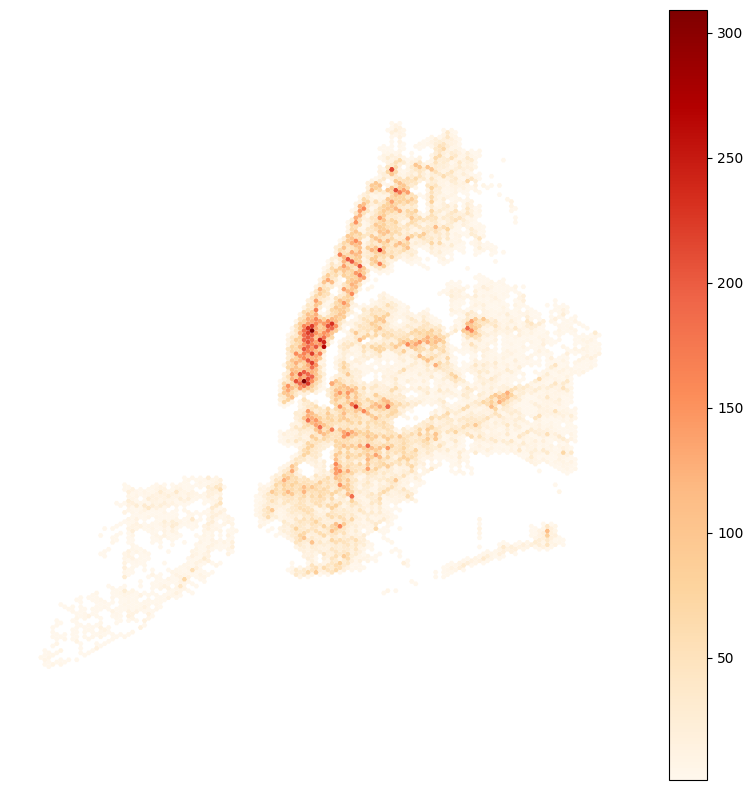

In [305]:
hexs_wdata = hexs_filtered.join( factors, on='id', how='left')
hexs_wdata = hexs_wdata.join( total_tally, on='id', how='left')
hexs_wdata = hexs_wdata.join( vechicle_types, on='id', how='left')
hexs_wdata = hexs_wdata.join( t, on='id', how='left')

del(t)
print( hexs_wdata.shape[0] , 'hexes have information' )
hexs_wdata.plot( column='total', cmap='OrRd', linewidth=0.1, ec=None, legend=True, figsize=(10, 10))
plt.axis('off')


Here I am cleaning some rows that i don't want to use in the regression.
- Too few points (<4)
- 2023 and 2024 not having any accidents.  

Also I am adjusting the 2024's numbers by remainig dates in the year.  

Here for each id (hex bin) I am using a linear regression to get a slope (trend) and r2 values.  
Here I am fine with a quite low r2 value because I have very little data. I checked a few plot individualyl to see that even 0.1,0.2 is a good enough value.  

 

In [242]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

gdf2['year'] = gdf2['CRASH DATE'].dt.year
gdf2['total'] = gdf2[['NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']].sum(axis=1)
gdf2['total_cycle'] = gdf2[['NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']].sum(axis=1)

t = gdf2.groupby(['year','id'], as_index=False).agg({'total':'sum', 'total_cycle':'sum'})

n_years = gdf2.groupby('id', as_index=False).agg({'year':'nunique'}).sort_values('year')
n_years = n_years[ n_years['year'] > 4 ]

last_years = t[t['year'].isin([2023,2024])].groupby('id').agg({'total':'sum'})
last_years = last_years[last_years[ 'total'] > 1 ]

t = t[t['id'].isin( n_years['id'].values ) & (t['id'].isin( last_years.index ))]

# constant to calculate the rest of the 2024
k = 1-(gdf2['CRASH DATE'].max().dayofyear / 365) + 1
t['total_cycle_adjusted'] = np.where( t['year'] == 2024, t['total_cycle'] * k, t['total_cycle'] )

def linear_regression( x,y ):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    x = x-np.min(x) # get it to 0
    y = y-np.min(y) +1 # get it to 0

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]

    r2 = r2_score(y, model.predict(x))

    return slope, r2

temp = []
for i,gr in t.groupby('id'):
    
    slope, r2 = linear_regression( gr['year'] , gr['total_cycle_adjusted'] )
    # print( f"Slope: {slope:.3f} R2: {r2:.3f} MAPE: {mape:.3f}" )
    temp.append( (i,slope,r2) )
    
trends = pd.DataFrame( data=temp, columns=['id','slope','r2'] )
trends.head()

,id,slope,r2
0,285,0.078292,0.215302
1,575,0.000000,1.000000
2,858,0.081478,0.330090
3,930,0.083222,0.449541
4,1214,0.003040,0.000608


7093 hexes have information


Text(0.0, 1.0, 'Locations where cyclist injured accidents\n are trending upwards (2014-2023)')

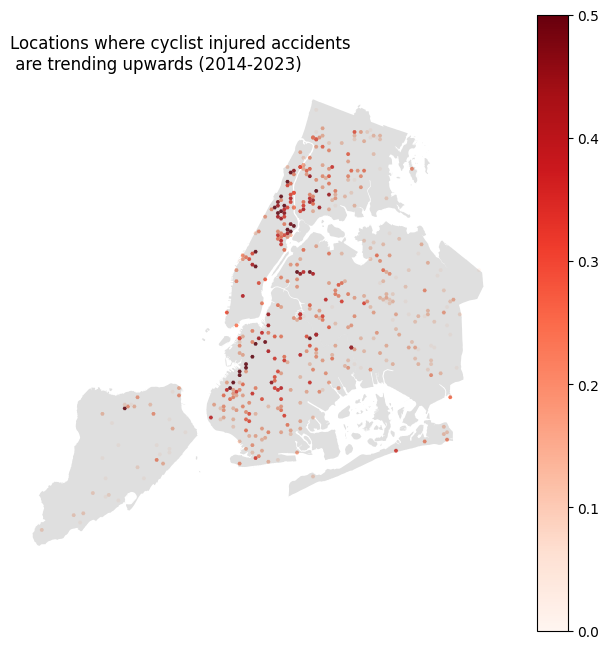

In [306]:
t = hexs_wdata.join( trends.set_index('id'), on='id', how='left')
print( t.shape[0] , 'hexes have information' )

fig,ax = plt.subplots(figsize=(8,8))
t[(t['slope'] >= 0) & (t['r2'] > 0.2)].plot(column='slope', cmap='Reds', linewidth=0.1, ec=None, legend=True, ax=ax, vmax=0.5 )
bb.plot(ax=ax , ec=None , fc='grey', alpha=0.25 )
ax.axis('off')
ax.set_title('Locations where cyclist injured accidents\n are trending upwards (2014-2023)', loc='left')

In [310]:
t = hexs_wdata.join( trends.set_index('id'), on='id', how='left')

t.loc[ t['slope'] > 0.2, 'trend'] = 'up'
t.loc[ t['slope'] < -0.2, 'trend'] = 'down'
t.loc[ t['slope'].between(-0.2,0.2), 'trend'] = 'flat'
t.loc[ t['r2'] < 0.2, 'trend'] = 'no trend'

hexs_wdata.shape[0] , t.shape[0]

(7093, 7093)

Some Boundary

(920331.0749450627, 1067236.1731018354, 129878.95765987103, 279652.1669738248)

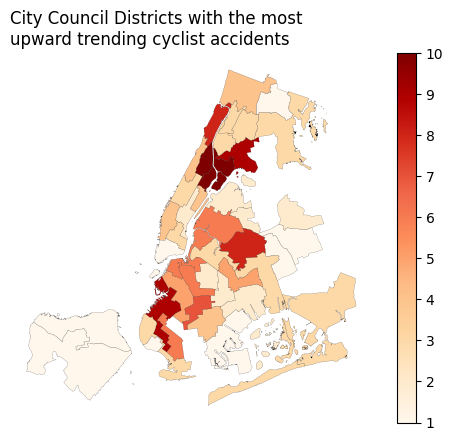

In [314]:
cds = r"D:\DATA\City Council Districts.geojson"
cds = gpd.read_file( cds )
cds = cds.to_crs(2263)

id_col = 'coun_dist'
cds2 = gpd.sjoin( t.set_geometry( hexs_wdata.centroid ) , cds , predicate='intersects', how='left' )

cds2 = cds2.pivot_table(index=id_col, columns='trend', aggfunc='size').sort_values('up', ascending=False)

fig,ax = plt.subplots()
cds.join( cds2, on='coun_dist' ).plot( ax=ax,  column='up', cmap='OrRd', linewidth=0.1, ec='black', legend=True, figsize=(8,8), vmax=10)
ax.set_title('City Council Districts with the most\nupward trending cyclist accidents', loc='left')
ax.axis('off')

###  Census  
include Population data to map population normalized accident rates.  
Here the poplation must be population + workers since traffic is more prevelant during the day.    

(-74.0595316, -73.6829004, 40.5498632272364, 40.9322385272353)

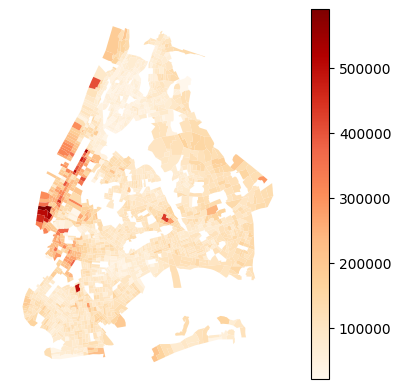

In [374]:
tracts = gpd.read_file(r"C:\Users\cansu\Downloads\NYC_DEMO\cb_2018_36_tract_500k\cb_2018_36_tract_500k.shp")
tracts = tracts[['AFFGEOID','GEOID','geometry']]

d1 = pd.read_csv( r"C:\Users\cansu\Downloads\NYC_DEMO\ACSST5Y2022.S1901_2024-09-24T133749\ACSST5Y2022.S1901-Data.csv", header=[1] )
d1 = d1.drop( columns = d1.columns[ d1.columns.str.contains('Margin') ] )
d1 = d1[['Geography','Estimate!!Households!!Mean income (dollars)']]
d1.columns = ['Geography','Mean Income']

d2 = pd.read_csv( r"C:\Users\cansu\Downloads\NYC_DEMO\ACSST5Y2022.S0101_2024-09-24T133828\ACSST5Y2022.S0101-Data.csv", header=[1] )
d2 = d2[['Geography' , 'Estimate!!Total!!Total population']]
d2.columns = ['Geography','Population'] 

data = d1.merge( d2, on='Geography' )
data = data.replace( '-' , np.nan )
data = data.replace( 'N' , np.nan )
data['Mean Income'] = data['Mean Income'].astype(float)

tracts = tracts.merge( data, left_on='AFFGEOID', right_on='Geography', how='left' )
tracts = tracts.dropna( subset=['Mean Income','Population'], axis=0 )

fig,ax = plt.subplots()
tracts.plot( column='Mean Income', cmap='OrRd', legend=True, ax=ax )
ax.axis('off')

In [447]:
hexs_wdata_2 = hexs_wdata.join(
    gpd.sjoin( hexs_wdata[['id','geometry']], tracts.to_crs(2263), how='inner', predicate='intersects' ).groupby('id').agg({
        'Mean Income':'mean',
        'Population':'mean'
    }),
    on='id', how='left'
)


In [448]:
# data from on the map. This is 2021 data. 
workers = gpd.read_file( r"D:\DATA\CENSUS\Workers\points_2021.shp" )
workers = workers.to_crs(2263)
workers = workers[['id','c000','geometry']]

In [449]:
hexs_wdata_2 = hexs_wdata_2.join(
    gpd.sjoin( workers, hexs_wdata_2, how='inner', predicate='intersects' ).groupby('id_right').agg({'c000':'sum'}),
    on='id', how='left'
)


In [450]:
# normalize population worker together so that they get equal weight
hexs_wdata_2['Population_norm'] = hexs_wdata_2['Population'] / hexs_wdata_2['Population'].max()
hexs_wdata_2['c000_norm'] = hexs_wdata_2['c000'] / hexs_wdata_2['c000'].max()

# score is a population score
hexs_wdata_2['score'] = (hexs_wdata_2['Population_norm'] + hexs_wdata_2['c000_norm']) / 2

Text(0.0, 1.0, 'Total accidents vs. Population (workers+living)')

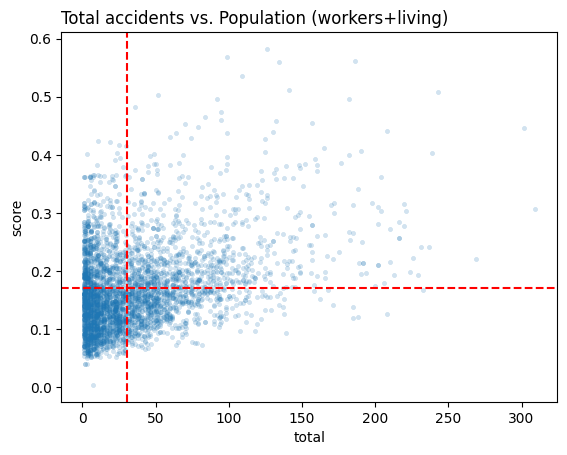

In [451]:
sns.scatterplot(
    data = hexs_wdata_2.reset_index() ,
    x = 'total',
    y = 'score',
    s=10, ec=None, alpha=0.2
)

plt.axvline( hexs_wdata_2['total'].mean(), color='red', linestyle='--')
plt.axhline( hexs_wdata_2['score'].mean(), color='red', linestyle='--')
plt.title( 'Total accidents vs. Population (workers+living)', loc='left')

(967593.8887763288, 1072426.6387763289, 140707.61390943095, 278621.9429557521)

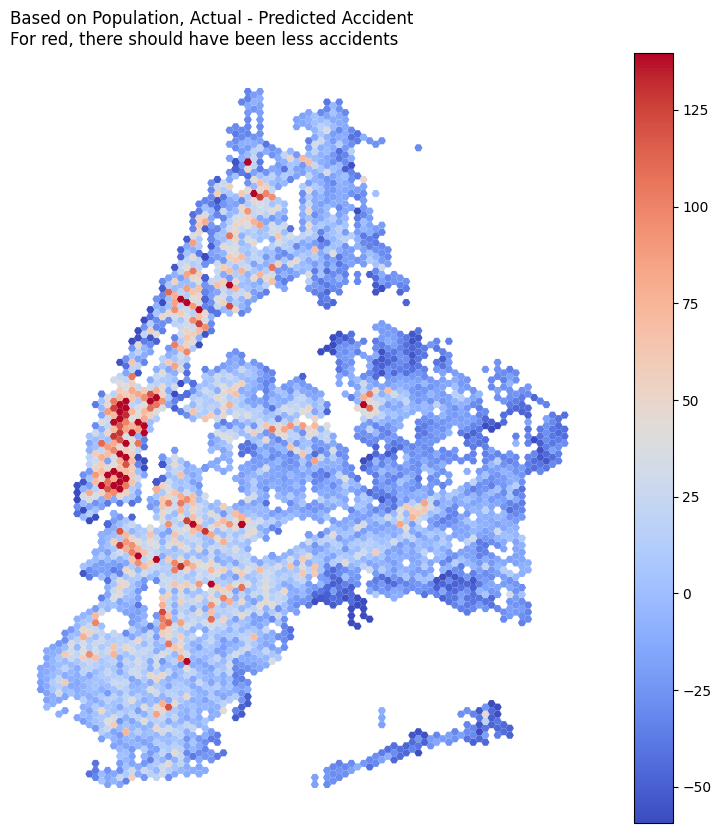

In [452]:
temp = hexs_wdata_2[ (hexs_wdata_2['total'].notnull()) & (hexs_wdata_2['score'].notnull()) ]

X = temp['score'].values.reshape(-1, 1)
y = temp[['total']].values

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the values
y_pred = model.predict(X)
y_pred = [i[0] for i in y_pred]

compare = pd.DataFrame( {'total': temp['total'].values, 'score': temp['score'].values, 'predicted_total': y_pred, 'id':temp['id'].values} )
compare['diff'] = compare['total'] - compare['predicted_total']

hexs_wdata_3 = hexs_wdata_2.join( compare.set_index('id')[['diff']], on='id', how='left')

hexs_wdata_3.plot( column='diff', cmap='coolwarm', legend=True, figsize=(10,10), vmax=hexs_wdata_3['diff'].quantile(0.99), vmin=hexs_wdata_3['diff'].quantile(0.01) )
plt.title( "Based on Population, Actual - Predicted Accident\nFor red, there should have been less accidents", loc='left' )
plt.axis('off')

Text(0.0, 1.0, 'Normalized Accidents\n(w. injuries) per 1000 people')

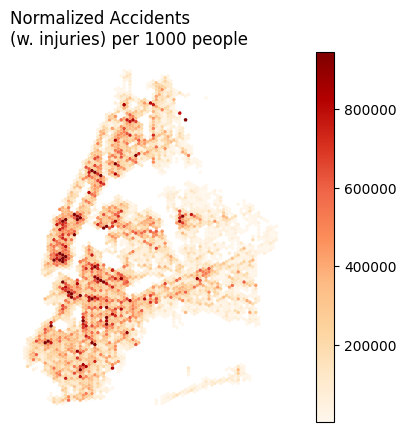

In [453]:
hexs_wdata_2['total_normalized'] = (hexs_wdata_2['total'] / hexs_wdata_2['score']) * 1000

fig,ax = plt.subplots()
hexs_wdata_2.plot( column='total_normalized', cmap='OrRd', linewidth=0.1, ec=None, legend=True, figsize=(12, 12) , vmax = hexs_wdata_2['total_normalized'].quantile(0.99), ax=ax)
ax.axis('off')
ax.set_title('Population Normalized Accidents\n(w. injuries) per 1000 people', loc='left')